In [1]:
import pandas as pd
import prefect
from prefect import task, Flow, Task

In [2]:
class BaseTask(Task):
    def __init__(self, name):
        super().__init__(name=name)

class PlusOneTask(BaseTask):
    def __init__(self, x, name=None):
        self._x = x
        super().__init__(name=name)
    
    def run(self):
        return self._x + 1

class MultipleTask(BaseTask):
    def __init__(self, multiple, name=None):
        self._multiple = multiple
        super().__init__(name=name)

    def run(self, x1, x2):
        return (x1 + x2) * self._multiple

In [3]:
class SimulatePipeline(object):
    
    def __init__(self, name):
        self._name = name
        self._flow = Flow(self._name)
        self._state = None
        self._tasks = {}
    
    def execute(self):
        self._state = self._flow.run()  
    
    def register(self, task_instance, depends=None, depends_with_data=None):      

        self._tasks[task_instance.name] = task_instance
        self._flow.add_task(task_instance)
        
        if depends:
            if not isinstance(depends, list):
                raise RuntimeError('depends must be a list of upstream task ids')
            
            depends_tasks = []
            
            for task in depends:
                task_name = task.name
                if task_name not in self._tasks:
                    raise ValueError(f'Invalide task_id {task_name}')
                depends_tasks.append(self._tasks[task_name])
                
            self._flow.set_dependencies(task_instance, upstream_tasks=depends_tasks)

        if depends_with_data:
            if not isinstance(depends_with_data, dict):
                raise RuntimeError('depends_with_data must be a dictionary for mapping argument names to upstream task outputs')            
        
            depends_tasks = {}
            
            for arg, task in depends_with_data.items():
                task_name = task.name
                if task_name not in self._tasks:
                    raise ValueError(f'Invalide task_id {task_name}')
                    
                depends_tasks[arg] = self._tasks[task_name]
            
            self._flow.set_dependencies(task_instance, keyword_tasks=depends_tasks)
    
    def get_output(self, task_name):
        return self._state.result[pipeline._tasks[task_name]]._result.value
    
    def visualize(self):
        return self._flow.visualize()     

In [4]:
pipeline = SimulatePipeline('Test Run')

task1 = PlusOneTask(name='plusonetask1', x=100)
pipeline.register(task1)

task2 = PlusOneTask(x=200)
pipeline.register(task2)

task3 = MultipleTask(name='multiple', multiple=3)
pipeline.register(task3, depends_with_data={'x1': task1, 'x2': task2})

In [5]:
pipeline.execute()

[2022-03-27 16:08:24+0800] INFO - prefect.FlowRunner | Beginning Flow run for 'Test Run'
[2022-03-27 16:08:24+0800] INFO - prefect.TaskRunner | Task 'plusonetask1': Starting task run...
[2022-03-27 16:08:24+0800] INFO - prefect.TaskRunner | Task 'plusonetask1': Finished task run for task with final state: 'Success'
[2022-03-27 16:08:24+0800] INFO - prefect.TaskRunner | Task 'PlusOneTask': Starting task run...
[2022-03-27 16:08:24+0800] INFO - prefect.TaskRunner | Task 'PlusOneTask': Finished task run for task with final state: 'Success'
[2022-03-27 16:08:24+0800] INFO - prefect.TaskRunner | Task 'multiple': Starting task run...
[2022-03-27 16:08:24+0800] INFO - prefect.TaskRunner | Task 'multiple': Finished task run for task with final state: 'Success'
[2022-03-27 16:08:24+0800] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


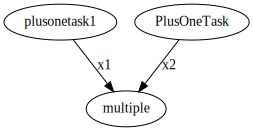

In [6]:
pipeline.visualize()

In [7]:
for key, r in pipeline._state.result.items():
    print(key, r._result.value)

<Task: plusonetask1> 101
<Task: PlusOneTask> 201
<Task: multiple> 906


In [8]:
pipeline._tasks

{'plusonetask1': <Task: plusonetask1>,
 'PlusOneTask': <Task: PlusOneTask>,
 'multiple': <Task: multiple>}

In [9]:
pipeline.get_output('PlusOneTask')

201